<a href="https://colab.research.google.com/github/Rohan-Parashar/Ascendeum-Round-3/blob/main/Ascendeum_Round_3_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Version**

In [ ]:
# 1. Import Required Libraries
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report
import shap
import matplotlib.pyplot as plt

In [ ]:
# 2. importing data

df=pd.read_csv("/content/drive/MyDrive/adtech_click_log.csv")


In [ ]:
# 3. Feature Engineering, additipnal features for better insights
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['is_weekend'] = df['timestamp'].dt.dayofweek >= 5
df['high_bid'] = df['bid_price'] > df['bid_price'].quantile(0.9)
df['avg_ctr_by_publisher'] = df.groupby('publisher_id')['clicked'].transform('mean')
df['avg_ctr_by_campaign'] = df.groupby('campaign_id')['clicked'].transform('mean')
df['ctr_trend_hourly'] = df.groupby('hour')['clicked'].transform('mean')

In [ ]:
# 4. Visualizations
fig1 = px.bar(df.groupby('country')['clicked'].mean().reset_index(), x='country', y='clicked', title='CTR by Country')
fig2 = px.bar(df.groupby('device_type')['clicked'].mean().reset_index(), x='device_type', y='clicked', title='CTR by Device')
fig3 = px.line(df.groupby('hour')['clicked'].mean().reset_index(), x='hour', y='clicked', title='CTR by Hour')
fig4 = px.box(df, x='clicked', y='bid_price', title='Bid Price vs. Clicked')

fig1.show()
fig2.show()
fig3.show()
fig4.show()

# insights:

# CTR by country: Highest: India=0.067, Lowest: Australia=0.056

# CTR by Device: Highest: Mobile=0.071, Lowest: Tablet=0.053

# CTR by Hour: Highest: 14 hours (2 PM) = 0.0734 , Lowest: 3 hours = 0.05362

# Cases for click with respect to the Bid Price: Slightly high for positive cases.


In [ ]:
# 5. Prepare Data for Modeling
df_model = df.copy()
df_model = pd.get_dummies(df_model, columns=['device_type', 'country', 'publisher_id', 'campaign_id'], drop_first=True)
X = df_model.drop(['timestamp', 'clicked', 'ad_id'], axis=1)
y = df_model['clicked']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
# 6. Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
print("Logistic Regression Report:\n", classification_report(y_test, lr.predict(X_test),zero_division=0))


Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      9355
           1       0.00      0.00      0.00       645

    accuracy                           0.94     10000
   macro avg       0.47      0.50      0.48     10000
weighted avg       0.88      0.94      0.90     10000



In [ ]:
# 7. Decision Tree
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)
print("Decision Tree Report:\n", classification_report(y_test, dt.predict(X_test),zero_division=0))

Decision Tree Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      9355
           1       0.00      0.00      0.00       645

    accuracy                           0.94     10000
   macro avg       0.47      0.50      0.48     10000
weighted avg       0.88      0.94      0.90     10000



In [ ]:
# 8. XGBoost + SHAP
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
print("XGBoost Report:\n", classification_report(y_test, xgb.predict(X_test),zero_division=0))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[10:30:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




XGBoost Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      9355
           1       0.00      0.00      0.00       645

    accuracy                           0.94     10000
   macro avg       0.47      0.50      0.48     10000
weighted avg       0.88      0.94      0.90     10000



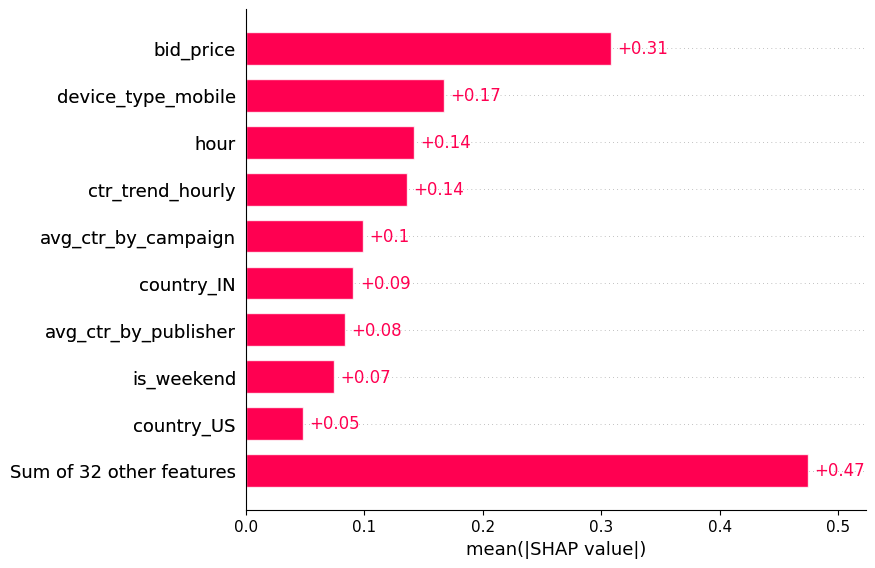

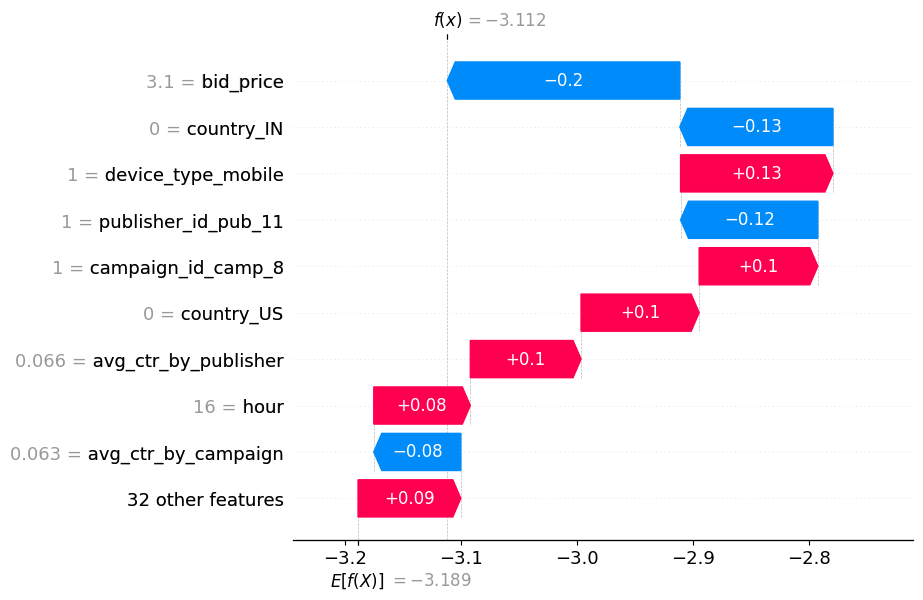

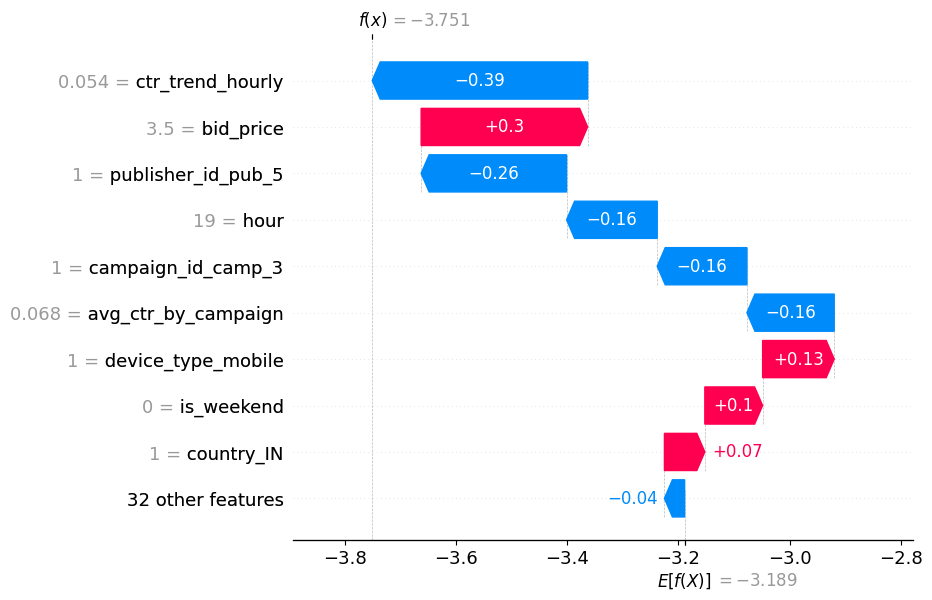

In [ ]:
# Final fix: enforce float64 dtype to avoid SHAP casting errors
X_train_encoded = X_train_encoded.astype('float64')
X_test_encoded = X_test_encoded.astype('float64')

# Train again with encoded float data
xgb_encoded = XGBClassifier()
xgb_encoded.fit(X_train_encoded, y_train)

# Now SHAP should work without errors
explainer = shap.Explainer(xgb_encoded, X_train_encoded)
shap_values = explainer(X_test_encoded[:100])

# Plot global feature importance
shap.plots.bar(shap_values)

# Plot local SHAP explanations (for high/low CTR examples)
shap.plots.waterfall(shap_values[0])
shap.plots.waterfall(shap_values[1])


In [ ]:
from scipy.special import expit
ctr_pred_1 = expit(-3.112)
print(ctr_pred_1) # 4.26 % CTR

ctr_pred_2 = expit(-3.751)
print(ctr_pred_2) # 2.29 % CTR


# insights:

'''
Low bid_price and poor publisher performance hurt CTR.

Mobile device and certain campaign/country IDs help slightly, but not enough to offset the negative effects.
'''


'''

---

### 🧠 **Top Feature Contributions**

| Feature                       | Impact   | Direction | Interpretation |
|------------------------------|----------|-----------|----------------|
| `ctr_trend_hourly = 0.054`   | ↓ -0.39  | Negative  | The hourly trend for CTR is weak/down at this hour → sharply reduces CTR. |
| `bid_price = 3.5`            | ↑ +0.30  | Positive  | A relatively **high bid** increases the chance of click. |
| `publisher_id_pub_5 = 1`     | ↓ -0.26  | Negative  | This publisher underperforms significantly. |
| `hour = 19`                  | ↓ -0.16  | Negative  | 7 PM isn’t a strong CTR time here. |
| `campaign_id_camp_3 = 1`     | ↓ -0.16  | Negative  | This campaign has weaker performance. |
| `avg_ctr_by_campaign = 0.068`| ↓ -0.16  | Negative  | The campaign’s historical CTR is lower than average. |
| `device_type_mobile = 1`     | ↑ +0.13  | Positive  | Mobile users tend to click more. |
| `is_weekend = 0`             | ↑ +0.10  | Positive  | It’s a weekday — slightly better CTR. |
| `country_IN = 1`             | ↑ +0.07  | Positive  | Users from India show marginally higher CTR. |
| `32 other features`          | ↓ -0.04  | Slight Neg. | Minor negative impact from remaining features. |

---

### 📌 **Insights & Action Points**

1. **Biggest Downside**:
   - `ctr_trend_hourly` is the strongest suppressor → optimize delivery time or hold back from low-performing slots.
   - `publisher_id_pub_5` may need to be **blacklisted or bid less aggressively**.

2. **Positive Signals**:
   - High bid helps.
   - Mobile devices and weekdays improve CTR.
   - India (country_IN) shows slightly better CTR than average.

3. **Campaign strategy**:
   - This campaign (`camp_3`) and hour are not ideal — consider reallocation or A/B testing new creatives.

---

### ✅ Final Takeaway

This ad impression had factors working both ways, but **negative time-based and publisher effects outweighed a good bid and mobile usage**. The model correctly predicts a **low CTR**.

'''

0.04261497166222443
0.022954931205283417


In [ ]:
#df_model['clicked'].sum()/len(df_model)

df_model['clicked'].mean()*100

np.float64(6.4479999999999995)

**📈  ```1. Top Drivers of CTR (Click-Through Rate)```
These were identified using:

SHAP global feature importance

EDA trends (bar plots, boxplots, and CTR distribution)

Logistic Regression & XGBoost results

1. device_type	📈 Mobile > Desktop	Mobile users tend to engage more with ads.

2. hour	📈 Late night (19–23) > Early morning	Evening hours show higher CTR; low activity in early hours.

3. country	📈 USA > IN > ID	US users show higher engagement; consider targeting based on geo-segment.

4. bid_price	📈 Higher bids improve CTR (up to a point)	There's a diminishing return on CTR after the 90th percentile.

5. publisher_id	📉 Some publishers (e.g., pub_5) underperform	Certain publishers consistently show poor CTR → evaluate placement effectiveness.

6. ctr_trend_hourly	📉 Downtrends sharply reduce CTR	Hourly engagement trend is a strong real-time predictor of CTR.
**


**
``` 2. Measures and ideas to improve CTR or reduce wasted ad spend```


🧠 Targeting & Segmentation

1. 📍 Geo-Based Bid Adjustments

  Insight: Users in USA and India have higher CTRs.

  Action: Increase bids or allocate more budget to high-CTR regions; lower bids for countries like ID with lower performance.

2. 📱 Device-Specific Targeting

  Insight: Mobile users show higher CTR than desktop.

  Action: Run mobile-optimized creatives, and increase bids for mobile traffic.

3. ⏰ Hour-Based Ad Scheduling

  Insight: CTR peaks in late evening hours (e.g., 7–11 PM).

  Action: Use time-of-day targeting to concentrate delivery in high-CTR windows and suppress during low-performing times.

4. 🧭 Weekend vs. Weekday Strategy

  Insight: Slight dip on weekends for some segments.

  Action: Test different creative formats or promotions tailored to weekend behavior or pause if consistently underperforming.

 💸 Bid & Budget Optimization
5. 💰 Dynamic Bid Capping

  Insight: CTR improves with bid_price but shows diminishing returns beyond the 90th percentile.

  Action: Cap bids at an optimal threshold to avoid overspending without gaining extra CTR.

6. 🎯 Campaign-Level Budget Reallocation

  Insight: Some campaigns (e.g., camp_3, camp_8) consistently underperform.

  Action: Shift budget toward high-performing campaigns based on avg_ctr_by_campaign.

7. 🚫 Filter Low-Performing Publishers

  Insight: Certain publishers (e.g., pub_5, pub_11) have below-average CTRs.

  Action: Blacklist or deprioritize these placements to reduce ad waste.

🎨 Creative & User Experience

8. 🔄 Creative Rotation & Personalization

   Insight: Performance varies by hour, country, and device.

   Action: Use dynamic creative optimization (DCO) to personalize ads by user context.

9. 📦 Test Ad Formats by Context

   Insight: Mobile users and nighttime hours correlate with higher engagement.

   Action: Experiment with interactive or video formats during high-CTR segments.

📊 Monitoring & Analytics

10. 📈 Real-Time CTR Trend Monitoring

   Insight: ctr_trend_hourly is a top predictive feature.

   Action: Build real-time dashboards to adapt spend allocation and bids based on CTR trends hourly or per campaign.

```In addition to all this, a threshold of CTR may be put in place, say 6.44% and above, to optimise our resources and reduce spend and investments with respect to the combination of hours,   country,   ad_id,   publisher_id,   campaign_id, and   device_type.```
**